<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Создадим-признаки" data-toc-modified-id="Создадим-признаки-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>Создадим признаки</a></span></li></ul></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#CatBoostRegression" data-toc-modified-id="CatBoostRegression-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>CatBoostRegression</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Требуется построить модель для такого предсказания.




## Подготовка

In [1]:
# !pip install statsmodels catboost lightgbm ydata_profiling prettytable


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import warnings

from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor

from prettytable import PrettyTable
from ydata_profiling import ProfileReport

warnings.filterwarnings('ignore')
%matplotlib inline

RANDOM_STATE = 12345

In [3]:
try:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('https://******/datasets/taxi.csv', index_col=[0], parse_dates=[0])
    
data.sort_index(inplace=True)

Проведем первичный анализ данных

In [4]:
profile = ProfileReport(data, title="Profiling Report", html={'style':{'full_width':True}})
profile.to_file("report_auto_raw.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
profile

## Анализ

График с разбивкой по часам

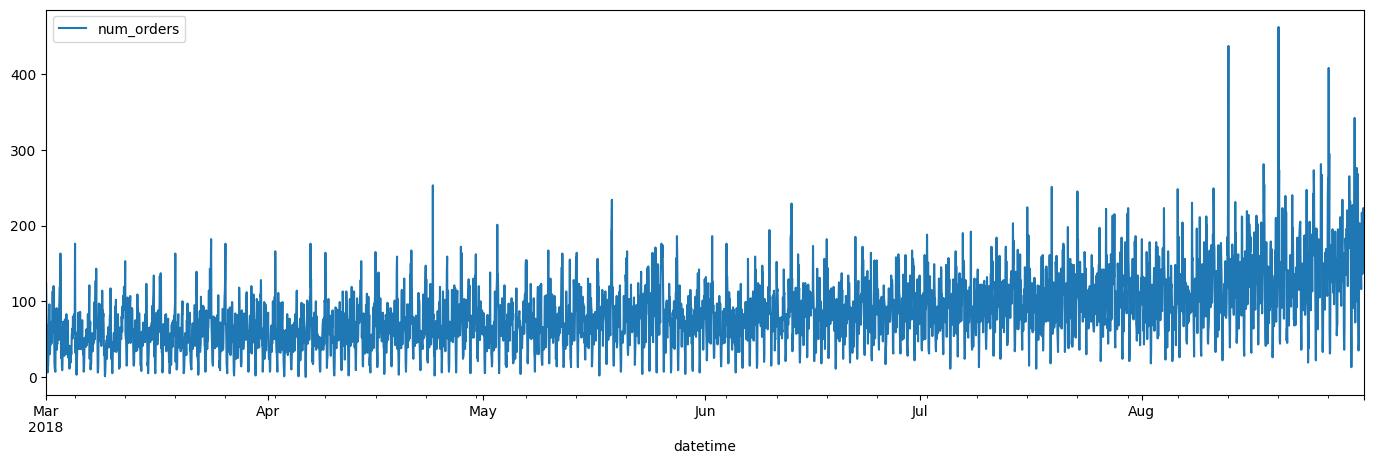

In [6]:
data = data.resample('1H').sum()
data.plot(figsize=(17,5));

На графике виден небольшой восходящий тренд, но в данных сложно разобраться, возьмем меньший период

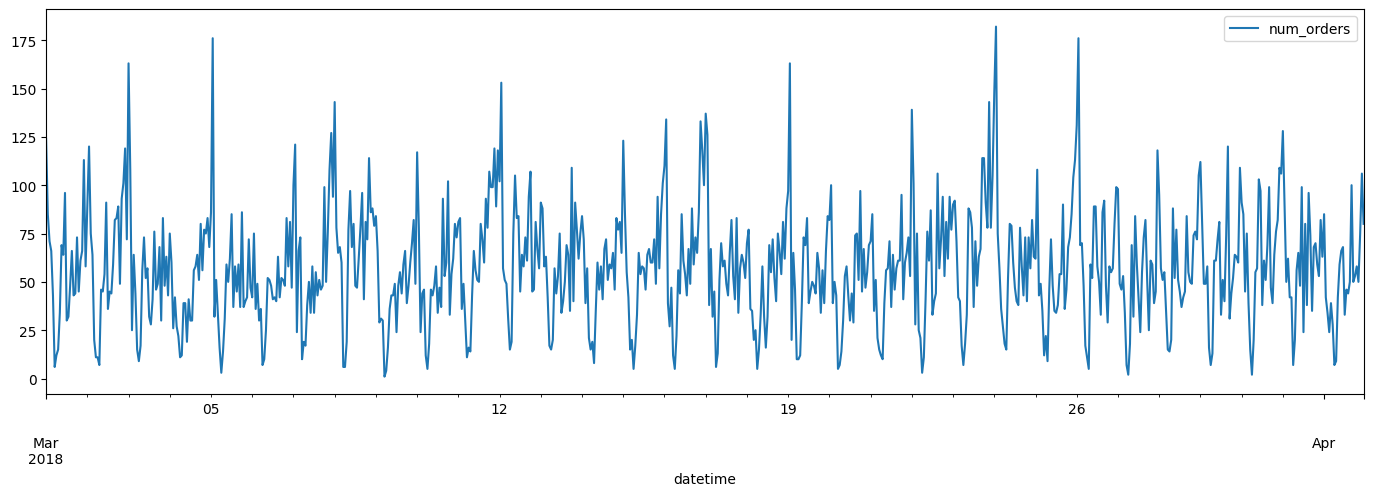

In [7]:
data['2018-03-01':'2018-04-01'].plot(figsize=(17,5));

Исследуем теренд, сезонность, и остаток декомпозиции данных

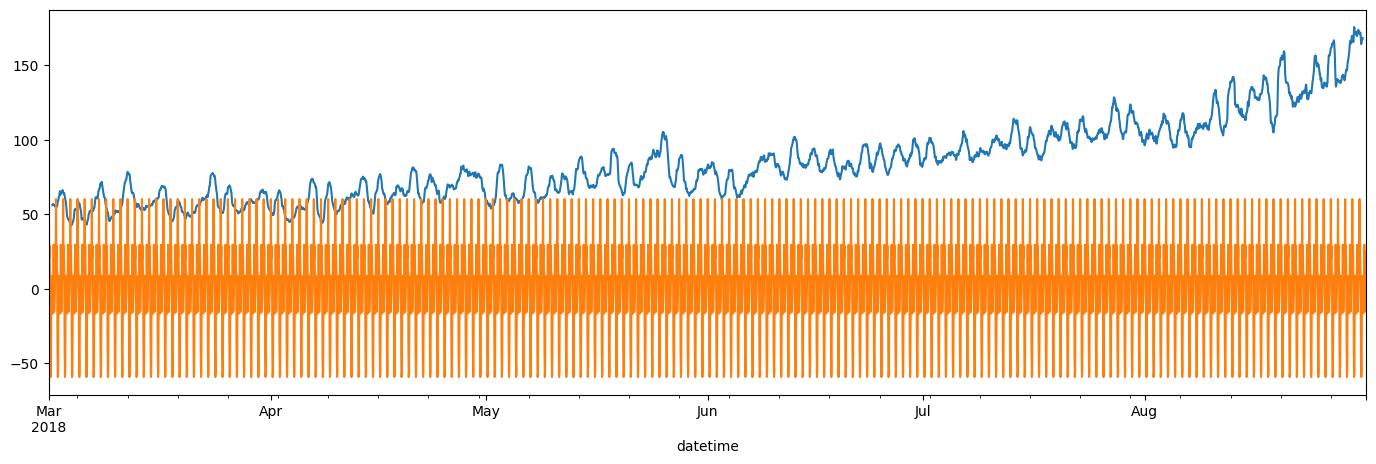

In [8]:
decomposed_data = seasonal_decompose(data)
decomposed_data.trend.plot(figsize=(17,5))
decomposed_data.seasonal.plot(figsize=(17,5));

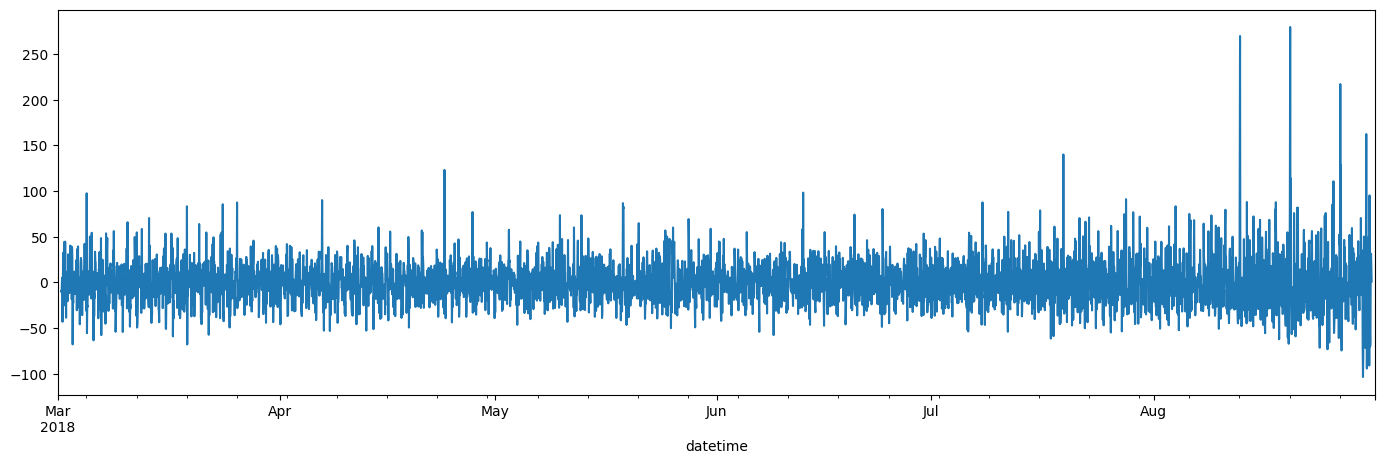

In [9]:
decomposed_data.resid.plot(figsize=(17,5));

Видим восходящий тренд, как и предполагалось, это значит что количество заказов такси растет, увеличим масштаб сезонности

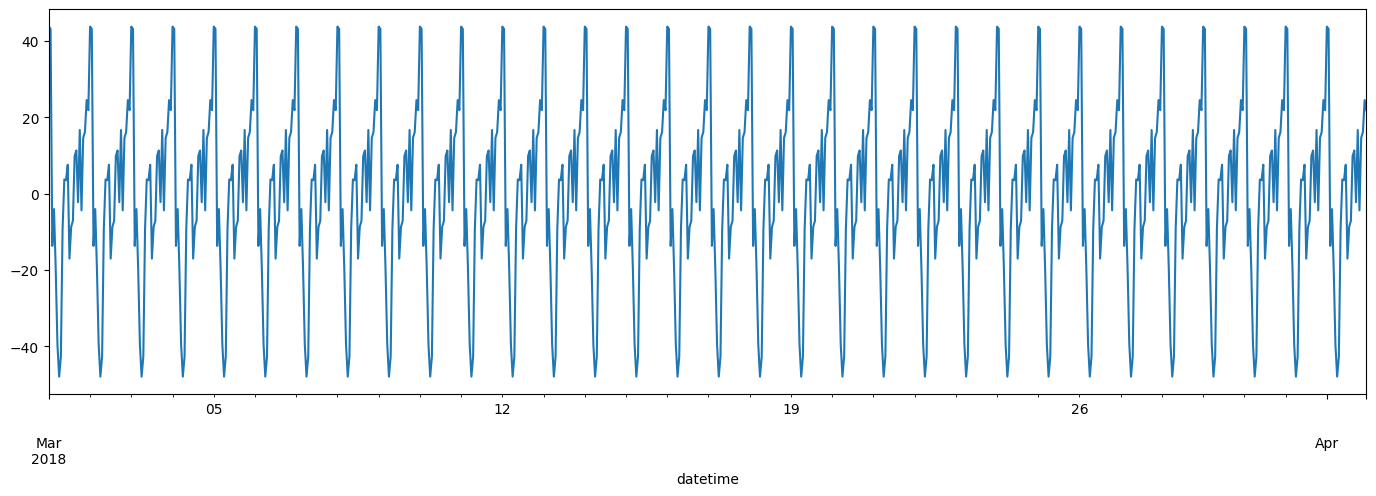

In [10]:
seasonal_decompose(data['2018-03-01':'2018-04-01']).seasonal.plot(figsize=(17,5));

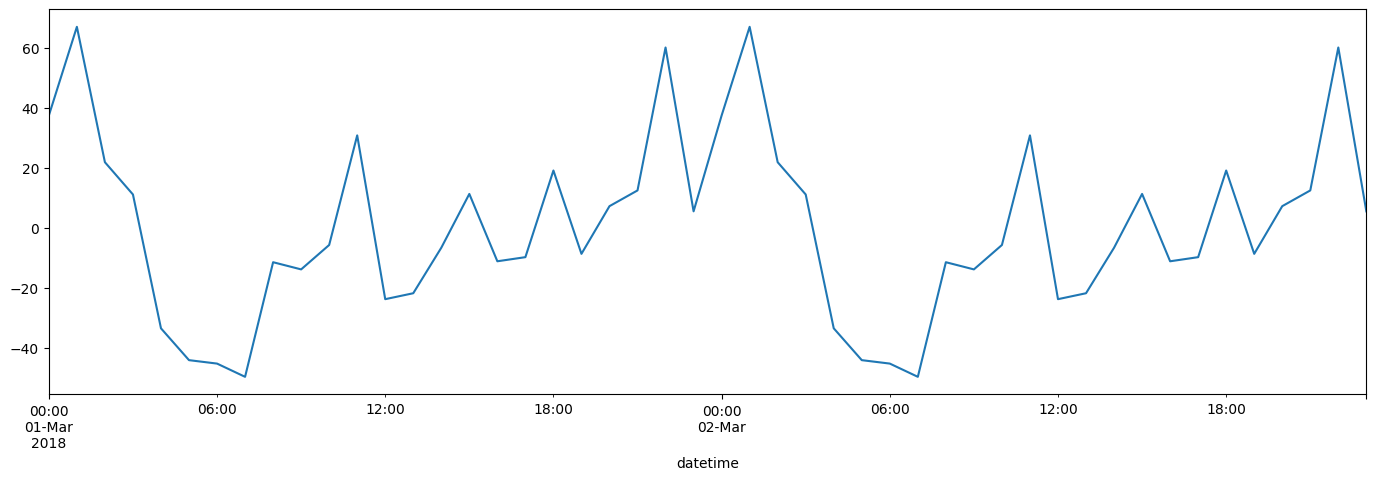

In [11]:
seasonal_decompose(data['2018-03-01':'2018-03-02']).seasonal.plot(figsize=(17,5));

#### Выводы
 - Дисперсия растет со временем
 - Тренд восходящий (кол-во заказов растет)
 - Наивысший спрос около часа ночи и в ~22 часа 
 - Локальные повышения спроса ~18 часов
 - Временной ряд не стационарный, есть тренд, который меняется со временем

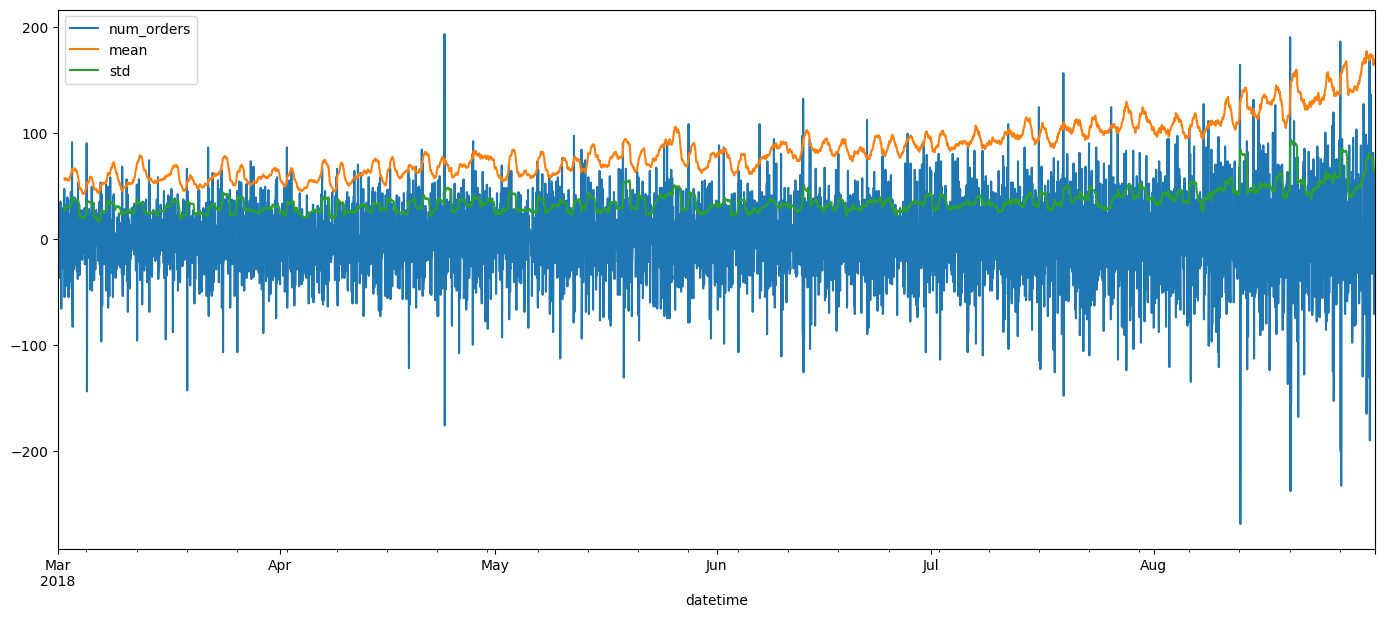

In [12]:
data_shift = data - data.shift()
data_shift['mean'] = data['num_orders'].rolling(24).mean()
data_shift['std'] = data['num_orders'].rolling(24).std()
data_shift.plot(figsize=(17,7));

Стандартное отклонение начинает расти в самом конце, в то время, как среднее растет заметно сильнее

#### Создадим признаки
Сезонность имеет размер в день, значит необходим дневной признак

Также необходим месяц и день недели отталкивая от показаний графиков

In [13]:
max_lag = 24
rolling_mean_size = 48

def make_features(data, column, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

In [14]:
data_backup = data

make_features(data,'num_orders', max_lag, rolling_mean_size)

train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

## Обучение

Используем несколько моделей регрессии, чтобы получить наилучший результат

### LinearRegression

In [15]:
tscv = TimeSeriesSplit(n_splits=8)

In [16]:
%%time

regressor = LinearRegression()

cv_RMSE_LR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=tscv, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5

print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR)

Mean RMSE from CV of LinearRegression = 27.146562377544374
CPU times: user 1.22 s, sys: 3.38 s, total: 4.59 s
Wall time: 108 ms


In [17]:
%%time

regressor = LinearRegression()
scaler = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaler),("linear_regression", regressor)])

cv_RMSE_LR_S = (cross_val_score(pipeline,
                                features_train, 
                                target_train, 
                                cv=tscv, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR_S)

Mean RMSE from CV of LinearRegression = 27.146562377544374
CPU times: user 2.46 s, sys: 6.27 s, total: 8.73 s
Wall time: 183 ms


### CatBoostRegressor

In [18]:
%%time

regressor = CatBoostRegressor()

hyperparams = [{'iterations': [100, 300, 500],
                'learning_rate':[0.05, 0.1, 0.2, 0.3],
                'depth': [3, 5, 7],
                'random_state':[RANDOM_STATE],
                'verbose':[ False]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error',cv=tscv)
clf.fit(features_train, target_train)


print('Best parameters:', clf.best_params_)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_CBR = (max(means)*-1) ** 0.5

Best parameters: {'depth': 7, 'iterations': 500, 'learning_rate': 0.05, 'random_state': 12345, 'verbose': False}
26.925065 for {'depth': 3, 'iterations': 100, 'learning_rate': 0.05, 'random_state': 12345, 'verbose': False}
26.024920 for {'depth': 3, 'iterations': 100, 'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}
25.823656 for {'depth': 3, 'iterations': 100, 'learning_rate': 0.2, 'random_state': 12345, 'verbose': False}
26.118685 for {'depth': 3, 'iterations': 100, 'learning_rate': 0.3, 'random_state': 12345, 'verbose': False}
25.655196 for {'depth': 3, 'iterations': 300, 'learning_rate': 0.05, 'random_state': 12345, 'verbose': False}
25.523792 for {'depth': 3, 'iterations': 300, 'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}
25.799265 for {'depth': 3, 'iterations': 300, 'learning_rate': 0.2, 'random_state': 12345, 'verbose': False}
26.452940 for {'depth': 3, 'iterations': 300, 'learning_rate': 0.3, 'random_state': 12345, 'verbose': False}
25.484584 for

### LGBMRegressor

In [19]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'learning_rate':[0.01,0.05,0.1,0.2],
                'num_leaves':[30,50,100,300],
                'random_state':[RANDOM_STATE]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error', cv=tscv)
clf.fit(features_train, target_train)

print('Best parameters', clf.best_params_)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

Best parameters {'learning_rate': 0.05, 'num_leaves': 30, 'random_state': 12345}
30.048401 for {'learning_rate': 0.01, 'num_leaves': 30, 'random_state': 12345}
29.861362 for {'learning_rate': 0.01, 'num_leaves': 50, 'random_state': 12345}
29.858062 for {'learning_rate': 0.01, 'num_leaves': 100, 'random_state': 12345}
29.830046 for {'learning_rate': 0.01, 'num_leaves': 300, 'random_state': 12345}
25.294212 for {'learning_rate': 0.05, 'num_leaves': 30, 'random_state': 12345}
25.560703 for {'learning_rate': 0.05, 'num_leaves': 50, 'random_state': 12345}
25.429332 for {'learning_rate': 0.05, 'num_leaves': 100, 'random_state': 12345}
25.464086 for {'learning_rate': 0.05, 'num_leaves': 300, 'random_state': 12345}
25.467737 for {'learning_rate': 0.1, 'num_leaves': 30, 'random_state': 12345}
25.632102 for {'learning_rate': 0.1, 'num_leaves': 50, 'random_state': 12345}
25.763536 for {'learning_rate': 0.1, 'num_leaves': 100, 'random_state': 12345}
25.852525 for {'learning_rate': 0.1, 'num_leaves

## Тестирование

### LinearRegression

CPU times: user 2.08 s, sys: 0 ns, total: 2.08 s
Wall time: 57.2 ms


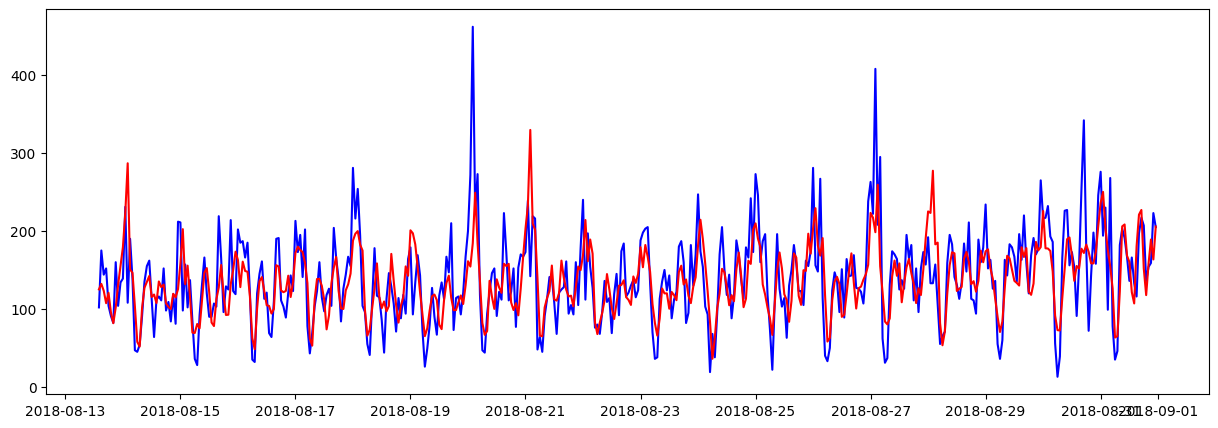

In [20]:
%%time

model = LinearRegression()
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
final_RMSE_LR = mean_squared_error(target_test, target_predict) ** 0.5

plt.figure(figsize=(15,5))
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         target_predict,
         'r-');

### CatBoostRegression

CPU times: user 25.8 s, sys: 1.59 s, total: 27.4 s
Wall time: 882 ms


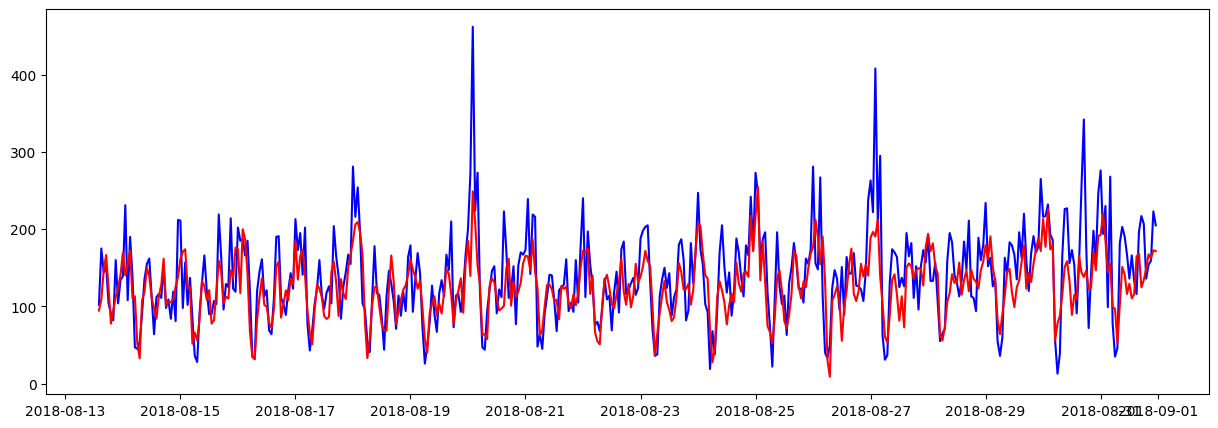

In [21]:
%%time

model = CatBoostRegressor(learning_rate=0.3,
                          depth=7,
                          iterations = 300,
                          random_state=RANDOM_STATE, 
                          verbose=False) 

model.fit(features_train, target_train)
target_predict = model.predict(features_test)
final_RMSE_CBR = mean_squared_error(target_test, target_predict) ** 0.5

plt.figure(figsize=(15,5))
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         target_predict,
         'r-');

### LGBMRegressor

CPU times: user 28.1 s, sys: 0 ns, total: 28.1 s
Wall time: 616 ms


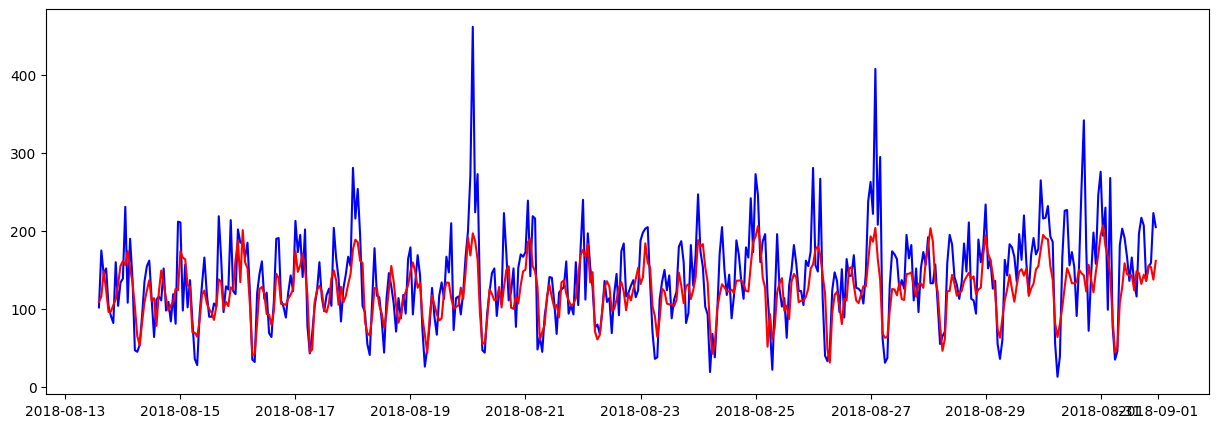

In [22]:
%%time

model = LGBMRegressor(learning_rate=0.05, 
                      num_leaves=50, 
                      random_state=RANDOM_STATE)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
final_RMSE_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5

plt.figure(figsize=(15,5))
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         target_predict,
         'r-');

In [23]:
table = PrettyTable(['Model', 'RMSE on CV', 'RMSE on Test'])
table.add_row(['LinearRegression', 
               f'{cv_RMSE_LR}',
               f'{final_RMSE_LR}'])

table.add_row(['CatBoostRegressor',
               f'{cv_RMSE_CBR}',
               f'{final_RMSE_CBR}'])

table.add_row(['LGBMRegressor',
               f'{cv_RMSE_LGBMR}',
               f'{final_RMSE_LGBMR}'])

print(table)

+-------------------+--------------------+-------------------+
|       Model       |     RMSE on CV     |    RMSE on Test   |
+-------------------+--------------------+-------------------+
|  LinearRegression | 27.146562377544374 |  44.8933272290983 |
| CatBoostRegressor | 24.74591671288926  | 42.75703497365531 |
|   LGBMRegressor   | 25.294211659329463 | 43.69736880247482 |
+-------------------+--------------------+-------------------+


В ходе работы были исследованы данные сервиса такси, созданы признаки, подобраны гиперпараметры и обучены модели регрессии, созданы предсказания и посчитана метрика RMSE.

Все модели прошли порог в RMSE < 48

Лучшая модель CatBoostRegressor c параметрами: `learning_rate=0.3`,`depth=7`,`iterations = 300`